# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [1]:
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

In [2]:
# These libraries may be useful to you

# !pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

In [3]:
# add any additional libaries you need here



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# Download NLTK data if not already downloaded
import nltk
nltk.download('brown')
from nltk.corpus import brown

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [7]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

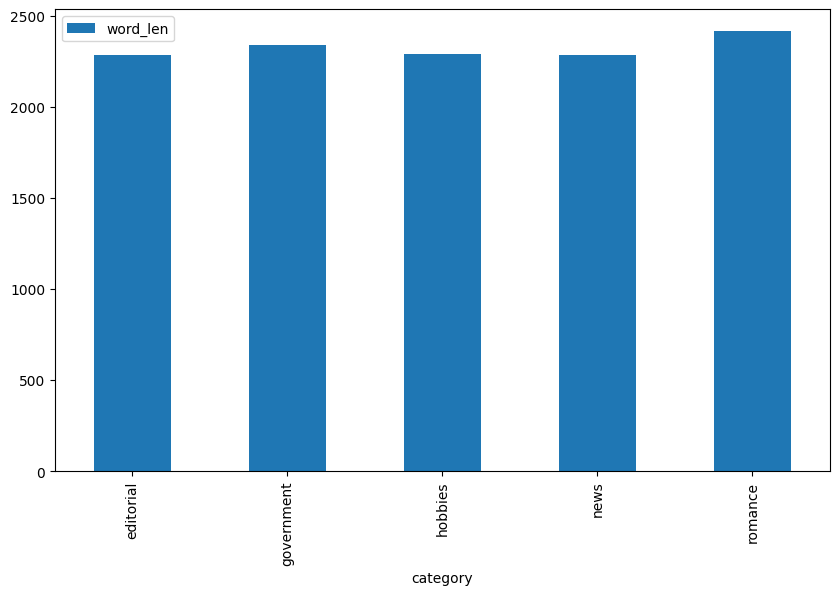

In [9]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

In [12]:
count_text_vectors

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: The data frames count_text_vectors and tfidf_text_vectors store different transformations of our text data. In count_text_vectors, each row represents a document and each column represents a unique word, with values indicating the frequency of each word in the documents. Tfidf_text_vectors also has rows for documents and columns for words, but the values are TF-IDF scores. These scores indicate how important a word is in a document by considering its frequency across all the documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [13]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [15]:
# Create DataFrame with Brown Corpus texts
df = pd.DataFrame({
    'text': [brown.raw(fileid) for fileid in brown.fileids()]
}, index=brown.fileids())

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Perform TF-IDF Vectorization
tfidf_text_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])

# Fit the NMF model
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Get the dominant topic for each document
topic_distribution = W_text_matrix.argmax(axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Create a mapping of Brown categories to document indices
brown_categories_mapping = {category: brown.fileids(categories=category) for category in brown.categories()}

# Initialize a dictionary to count documents per category and topic
category_topic_count = {category: [0] * 5 for category in brown.categories()}

# Count documents per category and topic
for doc_idx, topic in enumerate(topic_distribution):
    file_id = df.index[doc_idx]
    for category, fileids in brown_categories_mapping.items():
        if file_id in fileids:
            category_topic_count[category][topic] += 1

# Print comparison results
for category, counts in category_topic_count.items():
    print(f"Category: {category}, Topic Distribution: {counts}")


Category: adventure, Topic Distribution: [29, 0, 0, 0, 0]
Category: belles_lettres, Topic Distribution: [10, 0, 49, 0, 16]
Category: editorial, Topic Distribution: [1, 11, 0, 0, 15]
Category: fiction, Topic Distribution: [26, 0, 3, 0, 0]
Category: government, Topic Distribution: [0, 21, 1, 1, 7]
Category: hobbies, Topic Distribution: [1, 18, 7, 4, 6]
Category: humor, Topic Distribution: [5, 0, 4, 0, 0]
Category: learned, Topic Distribution: [1, 19, 29, 20, 11]
Category: lore, Topic Distribution: [6, 4, 24, 0, 14]
Category: mystery, Topic Distribution: [24, 0, 0, 0, 0]
Category: news, Topic Distribution: [3, 18, 4, 0, 19]
Category: religion, Topic Distribution: [0, 3, 14, 0, 0]
Category: reviews, Topic Distribution: [0, 2, 13, 0, 2]
Category: romance, Topic Distribution: [29, 0, 0, 0, 0]
Category: science_fiction, Topic Distribution: [5, 0, 1, 0, 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic NMF model compare to the original Brown categories?

A: The NMF model with five topics shows a good amount of similarity with some of the Brown Corpus categories. Categories such as adventure, fiction, mystery, and romance are predominantly found in Topic 00, suggesting a common narrative theme. Topics 01 and 04 contain most of the documents from government, news, and learned categories, indicating these topics cover informative and academic content. Categories like belles lettres and hobbies are more evenly spread across various topics, reflecting their broad and diverse nature. In summary, the NMF model effectively identifies primary themes within the corpus, though the diverse content in some categories is captured across multiple topics, highlighting the model’s ability to detect sub-genres and varied themes.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [23]:
# Your code here
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

lsa_model = TruncatedSVD(n_components=5, random_state=314)
lsa_text_matrix = lsa_model.fit_transform(tfidf_text_vectors)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic LSA model compare to the original Brown categories?



A: The LSA model's results show that some categories like adventure, fiction, humor, mystery, romance, and science_fiction are mainly associated with a single topic. Other categories like government, hobbies, learned, and lore spread across multiple topics, indicating diverse content. Categories like belles_lettres and editorial have a more balanced distribution across topics, but still lean towards specific themes.

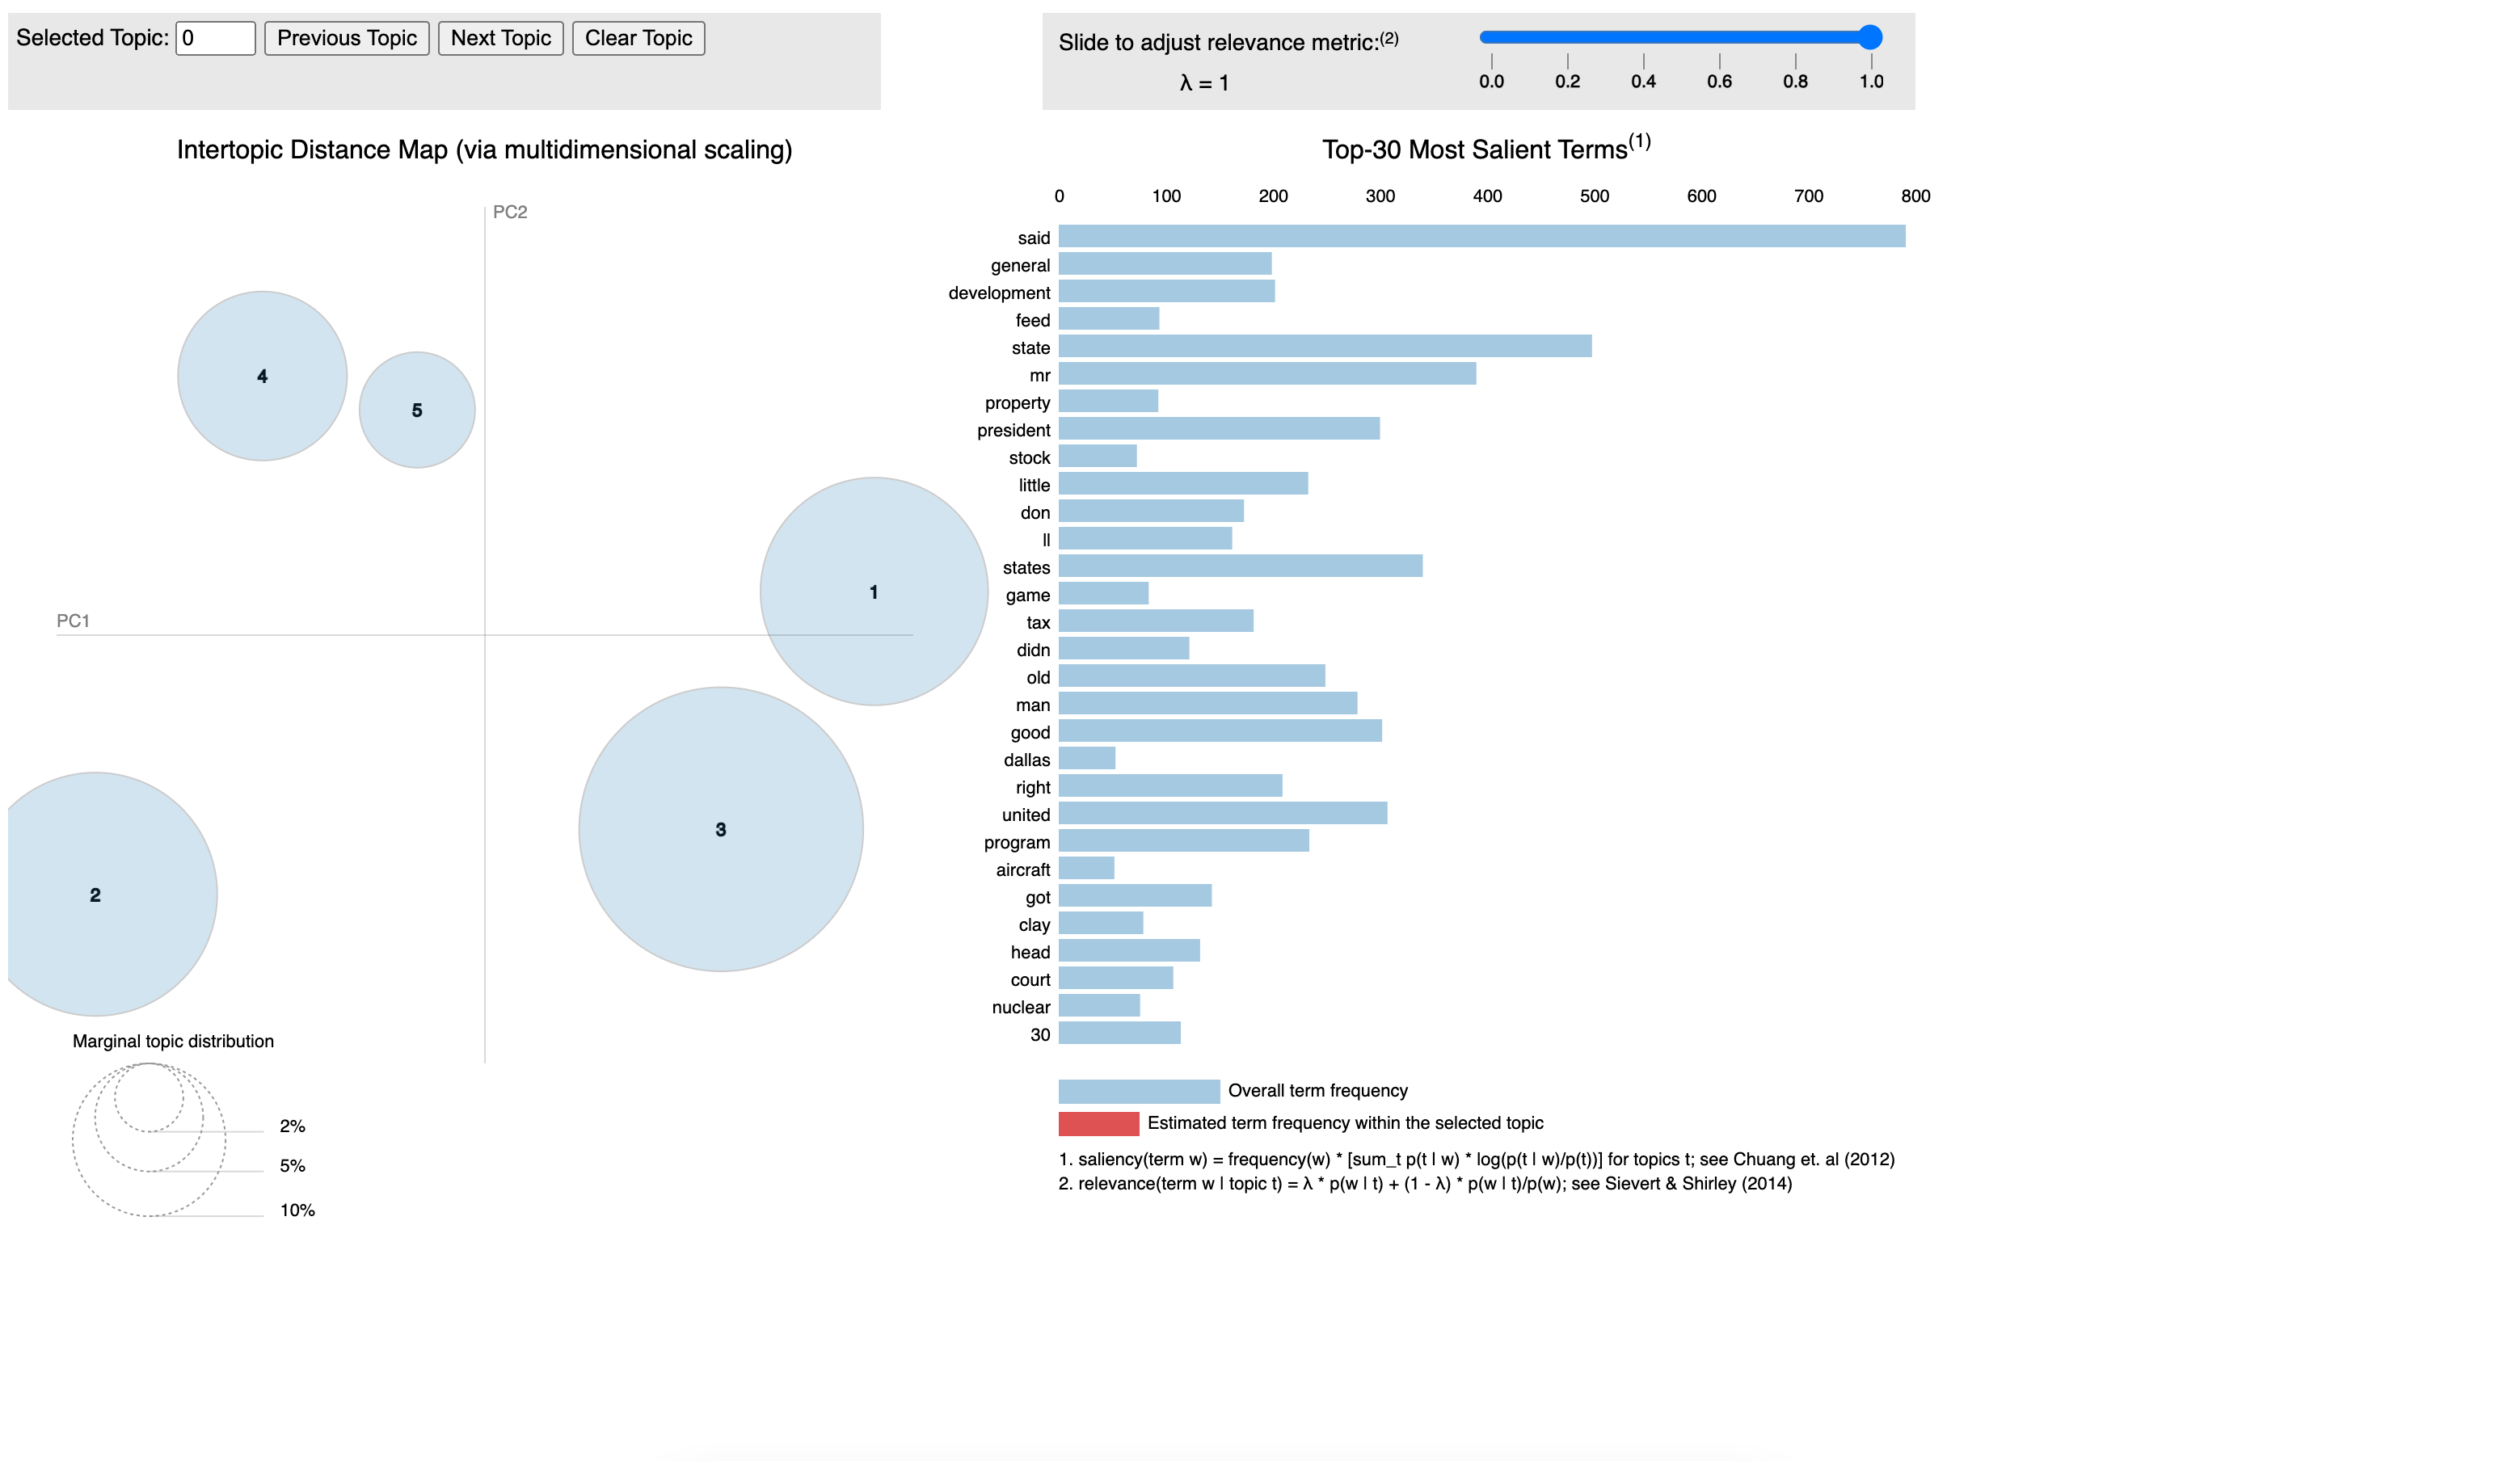

In [25]:
# Get the dominant topic for each document
topic_distribution = lsa_text_matrix.argmax(axis=1)

# Create a mapping of Brown categories to document indices
brown_categories_mapping = {category: brown.fileids(categories=category) for category in brown.categories()}

# Initialize a dictionary to count documents per category and topic
category_topic_count = {category: [0] * 5 for category in brown.categories()}

# Count documents per category and topic
for doc_idx, topic in enumerate(topic_distribution):
    file_id = df.index[doc_idx]
    for category, fileids in brown_categories_mapping.items():
        if file_id in fileids:
            category_topic_count[category][topic] += 1

# Print comparison results
for category, counts in category_topic_count.items():
    print(f"Category: {category}, Topic Distribution: {counts}")


Category: adventure, Topic Distribution: [29, 0, 0, 0, 0]
Category: belles_lettres, Topic Distribution: [56, 0, 19, 0, 0]
Category: editorial, Topic Distribution: [25, 1, 0, 0, 1]
Category: fiction, Topic Distribution: [29, 0, 0, 0, 0]
Category: government, Topic Distribution: [22, 6, 1, 1, 0]
Category: hobbies, Topic Distribution: [31, 2, 1, 2, 0]
Category: humor, Topic Distribution: [9, 0, 0, 0, 0]
Category: learned, Topic Distribution: [50, 4, 8, 17, 1]
Category: lore, Topic Distribution: [43, 0, 5, 0, 0]
Category: mystery, Topic Distribution: [24, 0, 0, 0, 0]
Category: news, Topic Distribution: [42, 0, 1, 0, 1]
Category: religion, Topic Distribution: [14, 1, 2, 0, 0]
Category: reviews, Topic Distribution: [17, 0, 0, 0, 0]
Category: romance, Topic Distribution: [29, 0, 0, 0, 0]
Category: science_fiction, Topic Distribution: [6, 0, 0, 0, 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# call display_topics on your model

display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  hl (0.91)
  said (0.25)
  nps (0.18)
  fw (0.18)
  mr (0.17)

Topic 01
  hl (3.08)
  af (0.34)
  united (0.16)
  states (0.15)
  state (0.14)

Topic 02
  fw (0.69)
  social (0.45)
  world (0.44)
  nps (0.39)
  human (0.36)

Topic 03
  af (12.49)
  temperature (1.26)
  cells (1.07)
  surface (1.03)
  pressure (0.96)

Topic 04
  af (60.30)
  mr (36.54)
  state (35.90)
  president (33.57)
  mrs (33.32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output?

A: There are some topic themes I am not entirely familair with, or might be some artifact, such as "hl", which we see in 00 and 01, and "af" which we see in multiple topics. Beyond that, there are some clear trends, with 01 dealing with the United States, and 02 being more broad, with topics like world, human and social. Topic 03 is more scientific, with temperature, cells, surface and pressure, all obviously related to science. Topic 04 is related to titles, specifically for the president.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [26]:
# Fit your LDA model here

# Fit the LDA model
lda_model = LatentDirichletAllocation(n_components=5, random_state=19)
lda_text_matrix = lda_model.fit_transform(count_text_vectors)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())



Topic #0:
development state use program states

Topic #1:
said man old little know

Topic #2:
state mr president said mrs

Topic #3:
feed home clay right head

Topic #4:
dallas stock aircraft motors general


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model?

A: Topic 0 is clearly related to government, 1 is interesting, with some words generally relating to an old man, and topic 2 is again related to the president, with topic three being another more difficult one for me to decipher. Topic 4 is related to business and industry.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: The model shows some consistencies for editorial and news categories, which are found in specific topics. Hobbies, lore, and religion categories are spread out over several topics. Multiple categories dont have any entries in the topics, which could mean the model didn't capture their themes well or their content wasn't unique enough.

In [36]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
pyLDAvis.save_html(lda_display, 'lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Assign each document to the most representative topic
topic_distribution = lda_text_matrix.argmax(axis=1)

# Create a mapping of Brown categories to document indices
brown_categories_mapping = {category: brown.fileids(categories=category) for category in brown.categories()}

# Initialize a dictionary to count documents per category and topic
category_topic_count = {category: [0] * 5 for category in brown.categories()}

# Count documents per category and topic
for doc_idx, topic in enumerate(topic_distribution):
    file_id = df.index[doc_idx]
    for category, fileids in brown_categories_mapping.items():
        if file_id in fileids:
            category_topic_count[category][topic] += 1

# Print comparison results
for category, counts in category_topic_count.items():
    print(f"Category: {category}, Topic Distribution: {counts}")

Category: adventure, Topic Distribution: [0, 0, 0, 0, 0]
Category: belles_lettres, Topic Distribution: [0, 0, 0, 0, 0]
Category: editorial, Topic Distribution: [9, 0, 14, 2, 2]
Category: fiction, Topic Distribution: [0, 0, 0, 0, 0]
Category: government, Topic Distribution: [0, 0, 0, 0, 0]
Category: hobbies, Topic Distribution: [3, 25, 0, 3, 5]
Category: humor, Topic Distribution: [0, 0, 0, 0, 0]
Category: learned, Topic Distribution: [0, 0, 0, 0, 0]
Category: lore, Topic Distribution: [9, 1, 5, 9, 1]
Category: mystery, Topic Distribution: [0, 0, 0, 0, 0]
Category: news, Topic Distribution: [9, 10, 23, 1, 1]
Category: religion, Topic Distribution: [2, 5, 8, 2, 0]
Category: reviews, Topic Distribution: [0, 0, 14, 2, 1]
Category: romance, Topic Distribution: [0, 0, 0, 0, 0]
Category: science_fiction, Topic Distribution: [0, 0, 0, 0, 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from google.colab import files
files.download('lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: I had a bit of trouble visualizing inline, so I made an html which worked well. The visualization helped show a clear picture of the different themes within the corpus. The principal component scatterplot shows how distinct the topics are from each other, essentially like a pca plot. For instance, Topic 2 is very separate in the bottom left, and topic 3 is relatively distint as well in the bottom right. It seems to cover unique themes related to government and statecraft, with words like "state," "president," and "government." The other topics are closer together, reflecting more nuanced or overlapping themes.

The salient terms graph highlights the most important words for each topic, giving insight into the various themes. Topic 1 focuses on business and government, with terms like "development," "state," and "business." Topic 2, featuring words like "said," "man," and "house," is less clear to me, but maybe conversation-based. Topic 4 includes terms like "home," "player," and "baseball," which suggests sports, and home could be the "home team". Topic 5, with words like "dallas," "stock," and "market," centers around industrial and commercial themes.
